This notebook uses matrix-based entropy [1, 2, 3] to analyze the "mutual information plane" of pretrained LLMs. For an introduction to this, check out the sentence_entropies.ipynb notebook.

Authors: Oscar Skean

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import os
import sys

sys.path.append("../")

In [17]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import numpy as np
import tqdm
from src.data import get_dataloader, normalize
import repitl.matrix_itl as itl


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

# Information Plane

The information plane is a probe on the model to analyze the mutual information between a pair of variables (input/output, input/layer representation, output/layer representation, etc.) as some quantity is changed (layer depth, context length, etc.).

In [18]:
def compute_information_plane(model, dataloader, var_A, var_B='layer', alpha=1):
    assert var_A in ['input', 'output']
    assert var_B in ['layer', 'output']

    mi_list = []
    counter = 0
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader):
            counter += 1
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            N, D = outputs.hidden_states[0].shape[1:]

            if var_A == 'input':
                A = normalize(outputs.hidden_states[0].squeeze()) # not really input, but the first hidden state
            elif var_A == 'output':
                A = normalize(outputs.hidden_states[-1].squeeze())

            if var_B == 'layer':
                B_list = [normalize(x.squeeze()) for x in outputs.hidden_states[1:]]
            if var_B == 'output':
                B_list = [normalize(outputs.hidden_states[-1].squeeze())]
            
            # get the covariance matrix for variable A
            if N > D:
                A_cov = A.T @ A
            else:
                A_cov = A @ A.T
            A_cov /= torch.trace(A_cov)
            A_cov = torch.clamp(A_cov, min=0).float()

            # get the covariance matrix for variable B
            B_cov_list = []
            for B in B_list:
                B = B.squeeze()
                if N > D:
                    B_cov = B.T @ B
                else:
                    B_cov = B @ B.T
                B_cov /= torch.trace(B_cov)
                B_cov = torch.clamp(B_cov, min=0)
                B_cov_list.append(B_cov.float())

            # compute the mutual information between A and each B
            mutual_informations = []
            entropy_A = itl.matrixAlphaEntropy(A_cov, alpha=alpha)
            for B_cov in B_cov_list:
                entropy_B = itl.matrixAlphaEntropy(B_cov, alpha=alpha)
                entropy_joint = itl.matrixAlphaEntropy(torch.pow(A_cov * B_cov, 0.5), alpha=alpha)


                mi = entropy_A + entropy_B - entropy_joint
                mutual_informations.append(mi.item())

            mi_list.append(mutual_informations)
            if counter > 300:
                break

    return mi_list

In [19]:
from transformers import BitsAndBytesConfig, QuantoConfig

def get_quantization_config(quantization: str):
    framework, bits = quantization.split("-")
    if framework == "quanto":
        assert bits in ["float8", "int8", "int4", "int2"]
        return QuantoConfig(weights=bits)
    elif framework == "bnb":
        assert bits in ["int8", "int4"]
        if bits == "int8":
            return BitsAndBytesConfig(load_in_8bit=True)
        elif bits == "int4":
            return BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_compute_dtype=torch.bfloat16,
                bnb_4bit_use_double_quant=True,
            )
    else:
        return None

In [21]:
from collections import defaultdict

MODELS = ["EleutherAI/pythia-14m", "EleutherAI/pythia-70m", "EleutherAI/pythia-160m", "EleutherAI/pythia-410m", "EleutherAI/pythia-1b"]
QUANTIZATION = ["none-bfloat16", "quanto-int2", "quanto-int4", "quanto-int8"]

input_to_layer_infos = defaultdict(dict)
output_to_layer_infos = defaultdict(dict)

for model_path in MODELS:
    for quantization in QUANTIZATION:
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        quantization_config = get_quantization_config(quantization)
        model = AutoModelForCausalLM.from_pretrained(
            model_path,
            output_hidden_states=True,
            device_map="auto",
            quantization_config=quantization_config,
            torch_dtype=torch.bfloat16,
        )
        dataloader = get_dataloader(tokenizer, "wikitext", split="train")
        model_name = model_path.split("/")[-1]
        input_to_layer_infos[model_name][quantization] = np.array(compute_information_plane(model, dataloader, "input", "layer", alpha=1)).mean(axis=0)
        output_to_layer_infos[model_name][quantization] = np.array(compute_information_plane(model, dataloader, "output", "layer", alpha=1)).mean(axis=0)

/home/djaniak/mambaforge/envs/info/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
  3%|▎         | 300/9311 [00:08<04:16, 35.12it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
  3%|▎         | 300/9311 [00:10<05:00, 30.00it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
  3%|▎         | 300/9311 [00:10<05:10, 29.00it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
  3%|▎         | 300/9311 [00:09<04:51, 30.96it/s]
Special tokens h

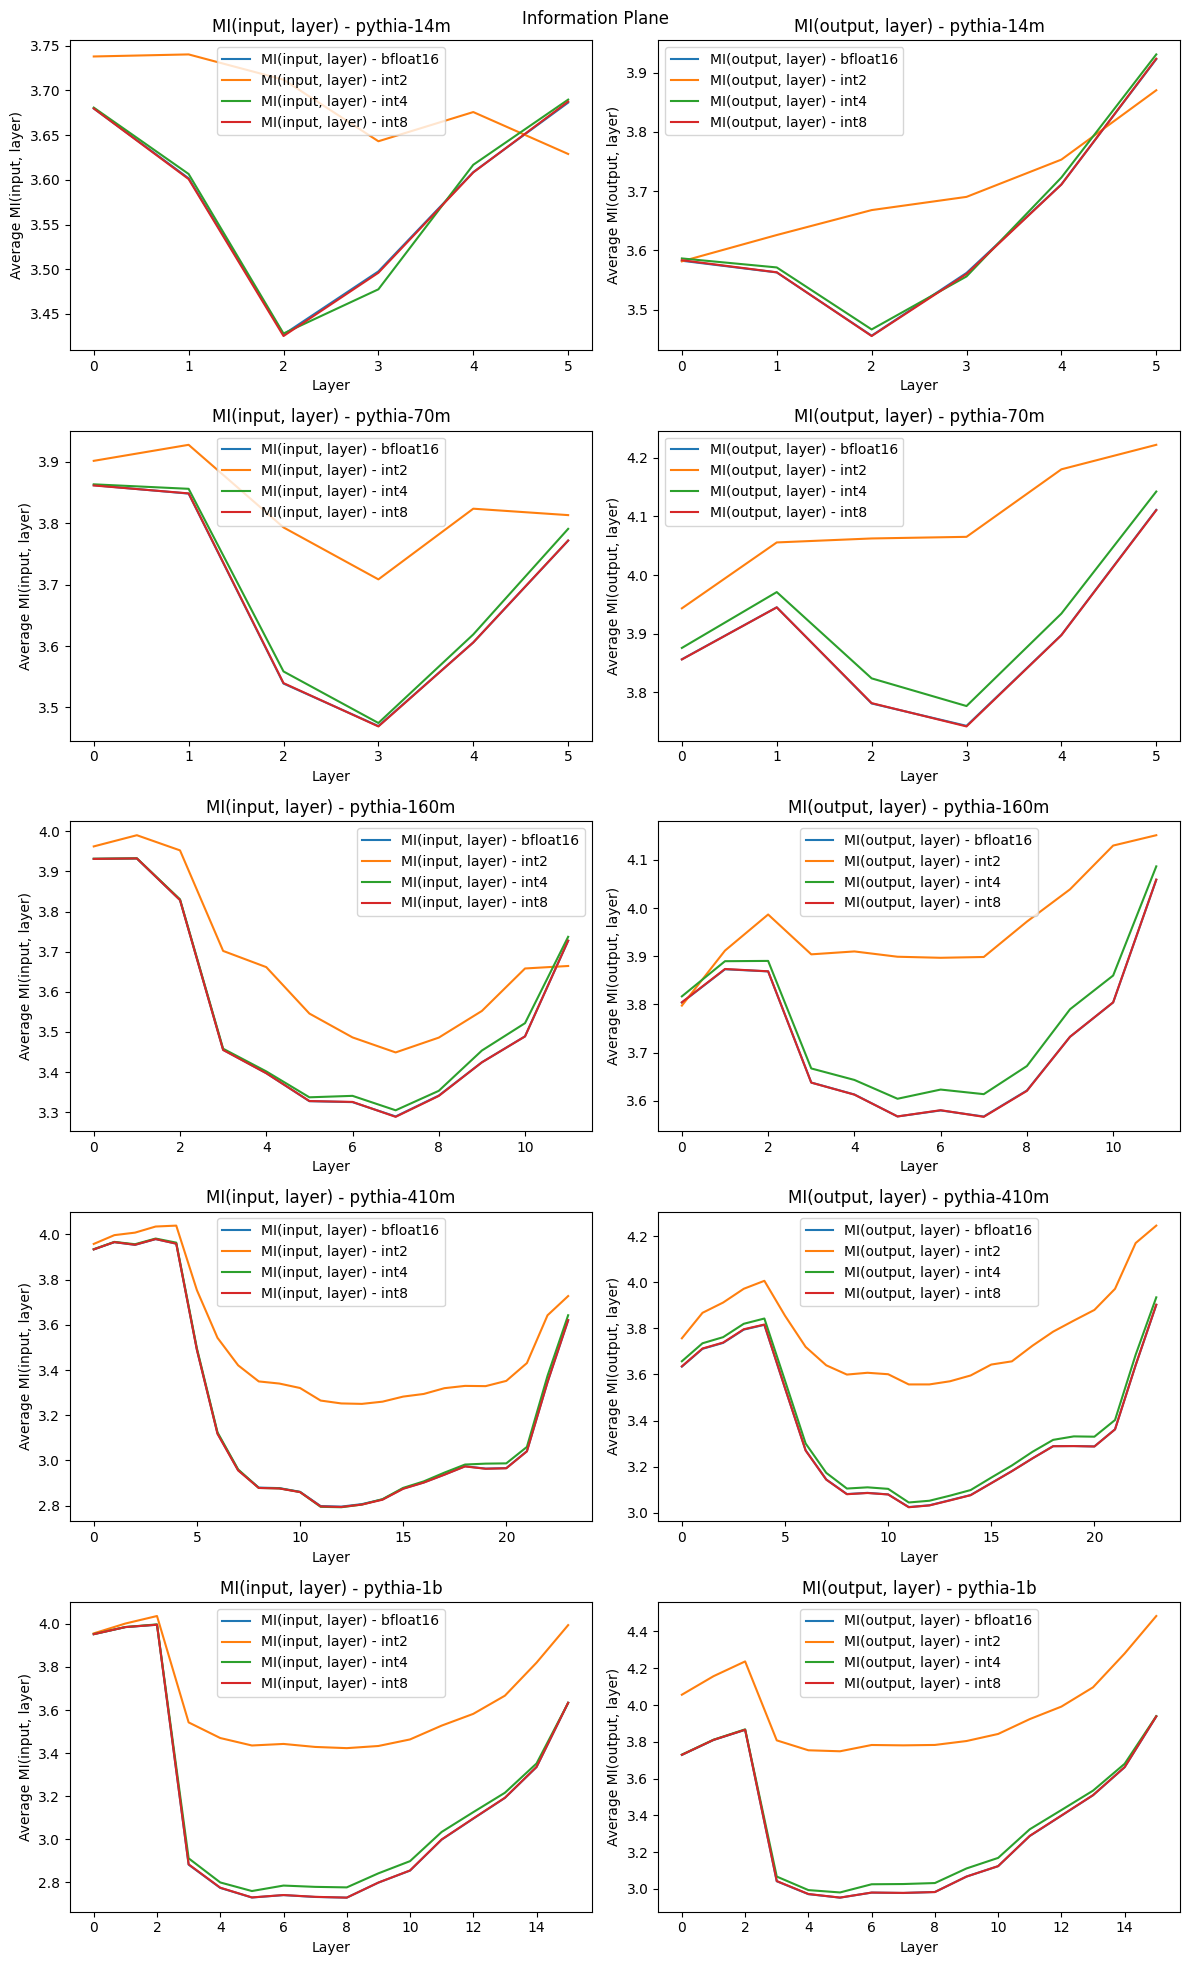

In [37]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(len(MODELS), 2, figsize=(12, 4*len(MODELS)))

for i, model_path in enumerate(MODELS):
    model_name = model_path.split("/")[-1]
    for quantization in QUANTIZATION:
        axes[i, 0].plot(input_to_layer_infos[model_name][quantization], label=f"MI(input, layer) - {quantization.split('-')[-1]}")
        axes[i, 0].set(title=f"MI(input, layer) - {model_name}", xlabel="Layer", ylabel=f"Average MI(input, layer)")
        axes[i, 0].legend()

        axes[i, 1].plot(output_to_layer_infos[model_name][quantization], label=f"MI(output, layer) - {quantization.split('-')[-1]}")
        axes[i, 1].set(title=f"MI(output, layer) - {model_name}", xlabel="Layer", ylabel=f"Average MI(output, layer)")
        axes[i, 1].legend()

fig.suptitle("Information Plane")
plt.tight_layout()
plt.show()

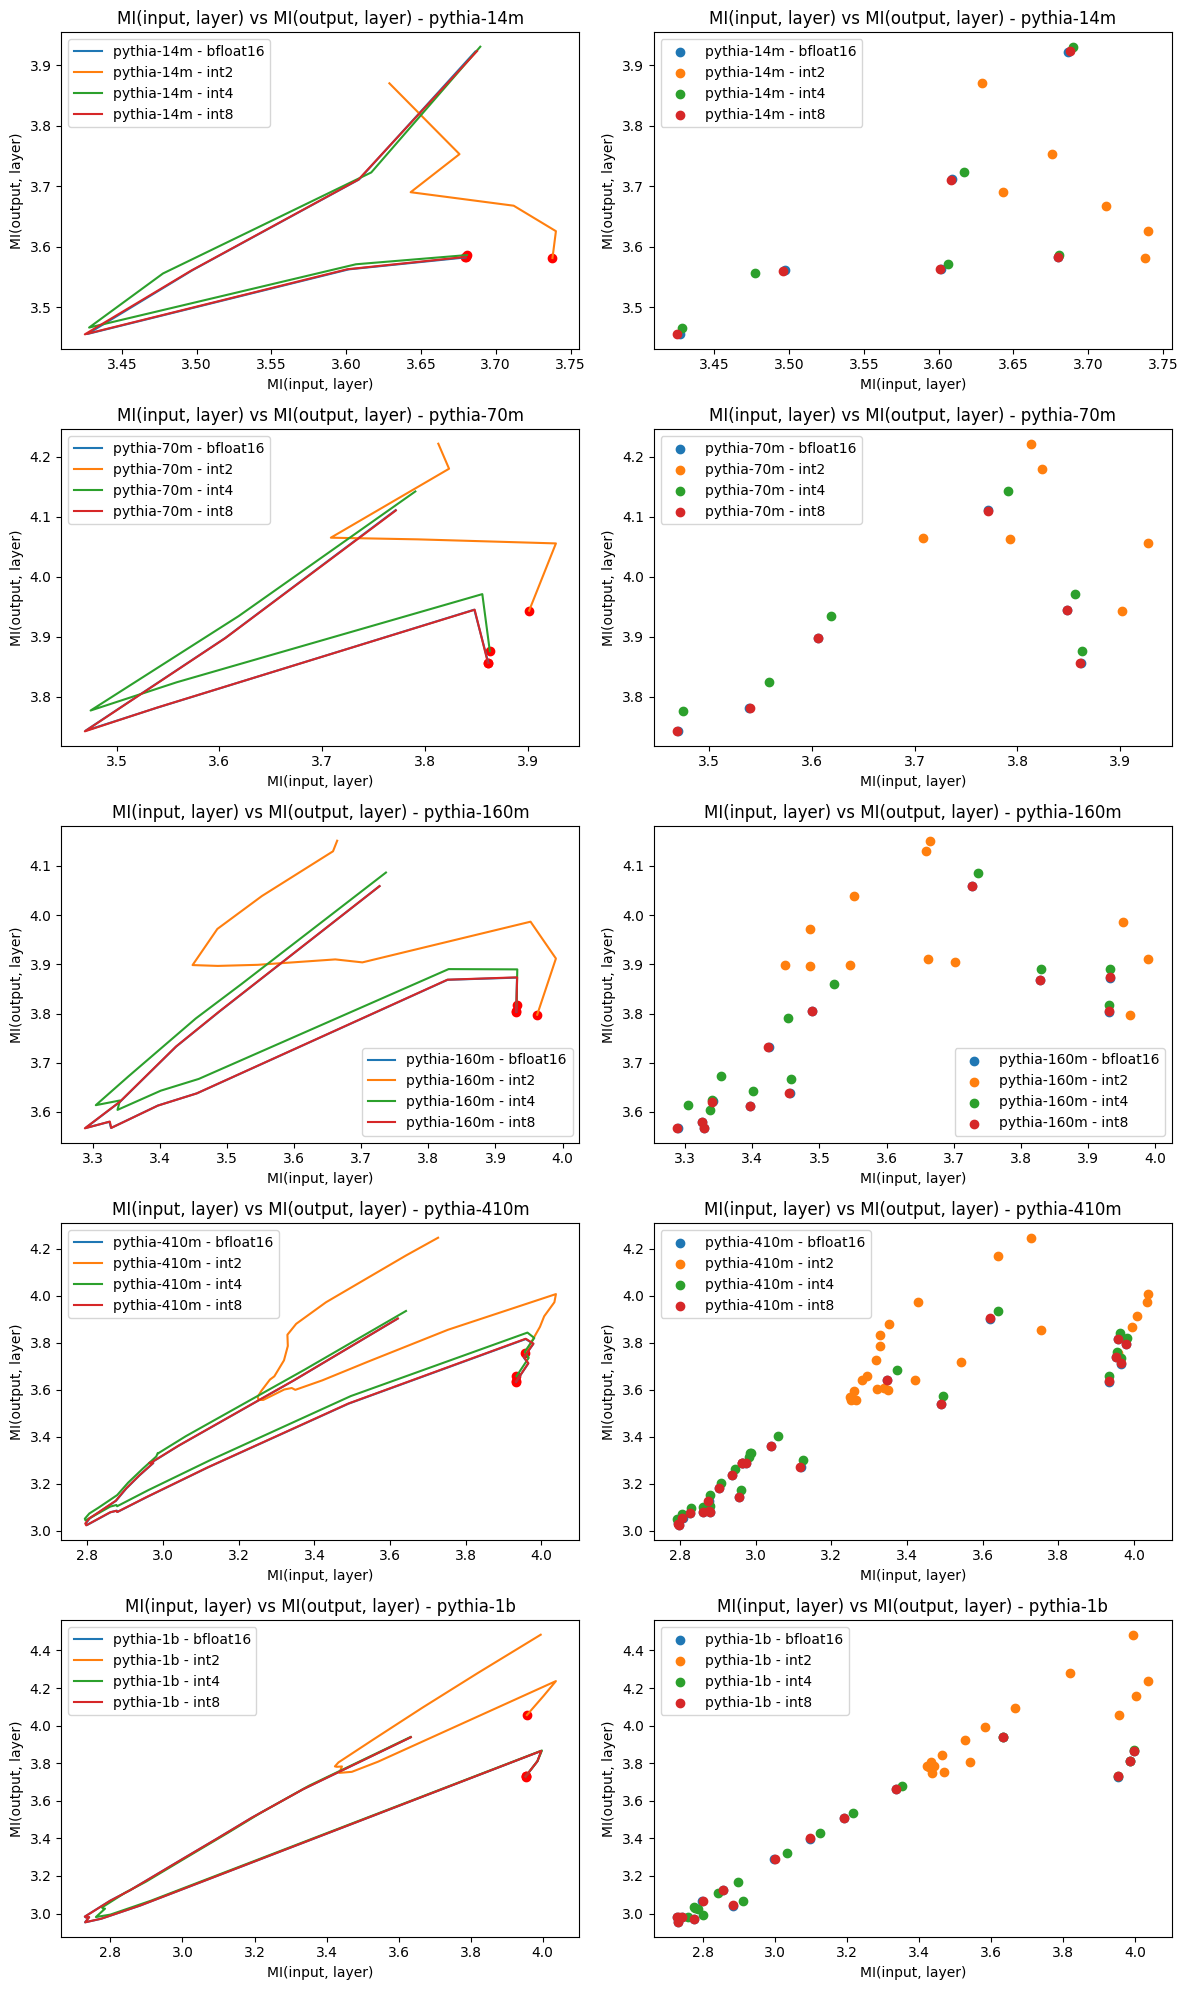

In [41]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(len(MODELS), 2, figsize=(12, 4*len(MODELS)))

for i, model_path in enumerate(MODELS):
    model_name = model_path.split("/")[-1]
    for quantization in QUANTIZATION:
        axes[i, 0].plot(input_to_layer_infos[model_name][quantization], output_to_layer_infos[model_name][quantization], label=model_name + " - " + quantization.split('-')[-1])
        axes[i, 1].scatter(input_to_layer_infos[model_name][quantization], output_to_layer_infos[model_name][quantization], label=model_name + " - " + quantization.split('-')[-1])
        axes[i, 0].set(title=f"MI(input, layer) vs MI(output, layer) - {model_name}", xlabel="MI(input, layer)", ylabel="MI(output, layer)")
        axes[i, 1].set(title=f"MI(input, layer) vs MI(output, layer) - {model_name}", xlabel="MI(input, layer)", ylabel="MI(output, layer)")
        axes[i, 0].scatter(input_to_layer_infos[model_name][quantization][0], output_to_layer_infos[model_name][quantization][0], color='red')  # highlight first point
        axes[i, 0].legend()
        axes[i, 1].legend()

plt.tight_layout()
plt.show()